## 1. Defining the Problem and Assembling a Dataset

**Problem:** Classify images of 10 different objects from the Imagenette dataset - a smaller subset of ImageNet designed for faster experimentation.

**Why TFDS?** TensorFlow Datasets provides easy access to common ML datasets with consistent APIs.

<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/Imagenette/Imagenette%20-%20TFDS%20Color%20Image%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imagenette - TFDS Color Image Example

This notebook demonstrates the **Universal ML Workflow** for multi-class image classification using TensorFlow Datasets (TFDS).

## Learning Objectives

By the end of this notebook, you will be able to:
- Load image datasets from **TensorFlow Datasets (TFDS)**
- Preprocess color images: Resize → Grayscale → Flatten → Normalize
- Handle 10-class image classification
- Use **Top-N Accuracy** as an additional evaluation metric
- Apply grid search for hyperparameter tuning on image data

---

## Dataset Overview

| Attribute | Description |
|-----------|-------------|
| **Source** | [TensorFlow Datasets - imagenette/160px](https://www.tensorflow.org/datasets/catalog/imagenette) |
| **Problem Type** | Multi-Class Classification (10 classes) |
| **Classes** | Tench, English springer, Cassette player, Chain saw, Church, French horn, Garbage truck, Gas pump, Golf ball, Parachute |
| **Data Balance** | Nearly Balanced |
| **Original Size** | 160×160 color images |
| **Preprocessing** | Resize to 64×64 → Grayscale → Flatten (4096 features) |

---

<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/Imagenette/Imagenette%20-%20TFDS%20Color%20Image%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imagenette - TFDS Color Image Example

This notebook demonstrates the **Universal ML Workflow** applied to a multi-class color image classification problem using TensorFlow Datasets.

## 2. Choosing a Measure of Success

- **Top-1 Accuracy:** Did the model's top prediction match the true class?
- **Top-N Accuracy:** Was the true class in the model's top N predictions? (Useful for 10-class problems)
- **Precision, Recall, AUC:** Per-class and overall performance

## 3. Deciding on an Evaluation Protocol

Standard hold-out test set + validation set + K-fold cross-validation for hyperparameter tuning.

## 4. Preparing Your Data

### 4.1 Import Libraries and Load TFDS Dataset

In [ ]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow_datasets as tfds
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# Keras Tuner for hyperparameter search
!pip install -q -U keras-tuner
import keras_tuner as kt

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [280]:
DATASET = 'imagenette/160px'
RESIZE = (64, 64, 3)
GRAY_SCALE = True

In [281]:
ds = tfds.load(DATASET, split='all', shuffle_files=True)

images, labels = [], []
for entry in ds.take(len(ds)) :
    image, label = entry['image'], entry['label']
    
    image, label = image.numpy(), label.numpy()
    
    image = resize(image, RESIZE, anti_aliasing=True)
            
    if GRAY_SCALE :
        image = rgb2gray(image)
        
    images.append( image )
    labels.append( label )

In [86]:
# list of images to numpy array
X = np.array(images)

# flatten 2D image array to 1D array
X = X.reshape( (X.shape[0], -1) )

In [87]:
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# label -> one-hot encoded vector
y = np_utils.to_categorical(label_encoder.transform(labels))

In [88]:
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=labels, 
                                                    random_state=SEED, shuffle=True)

In [89]:
# normalise pixels from [0, 255] to [0, 1]
X_train, X_test = X_train/255, X_test/255

In [90]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train.argmax(axis=1),
                                                 shuffle=True, random_state=SEED)

## 5. Developing a Model That Does Better Than a Baseline

Baseline for 10-class balanced problem: 10% accuracy (random guessing).

In [93]:
# number of samples per each class
counts = np.sum(y, axis=0)

# the dataset is balanced. one class is slightly less than the others, but minimal.
counts

array([1350., 1350., 1350., 1244., 1350., 1350., 1350., 1350., 1350.,
       1350.], dtype=float32)

In [94]:
baseline = max(counts) / sum(counts)

baseline

0.10079139913394057

In [95]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [105]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y,
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [106]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'RMSprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [153]:
learning_rate = 0.1

slp_model = deep_neural_network(hidden_layers=0,
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 10)                40970     
                                                                 
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 128
EPOCHS = 300

In [ ]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

In [156]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_slp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Validation): 0.31 (baseline=0.10)
Precision (Validation): 0.65
Recall (Validation): 0.04
AUC (Validation): 0.74


In [157]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

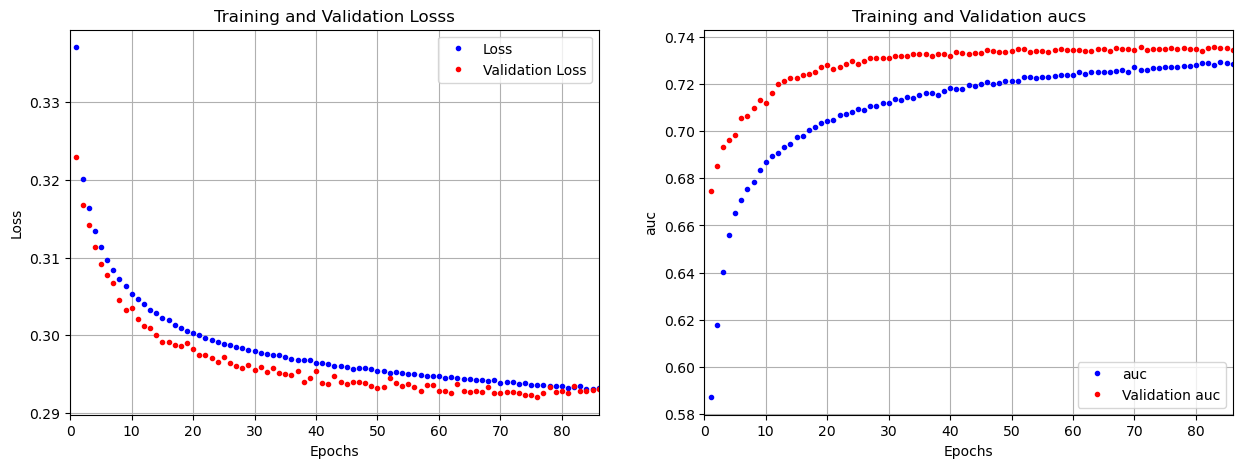

In [158]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

## 6. Scaling Up: Developing a Model That Overfits

Adding capacity to learn complex image patterns.

In [206]:
learning_rate = 0.0025

mlp_model = deep_neural_network(hidden_layers=1, hidden_neurons=32,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                loss=LOSS_FUNC, metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 32)                131104    
                                                                 
 dense_37 (Dense)            (None, 10)                330       
                                                                 
Total params: 131,434
Trainable params: 131,434
Non-trainable params: 0
_________________________________________________________________


In [207]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

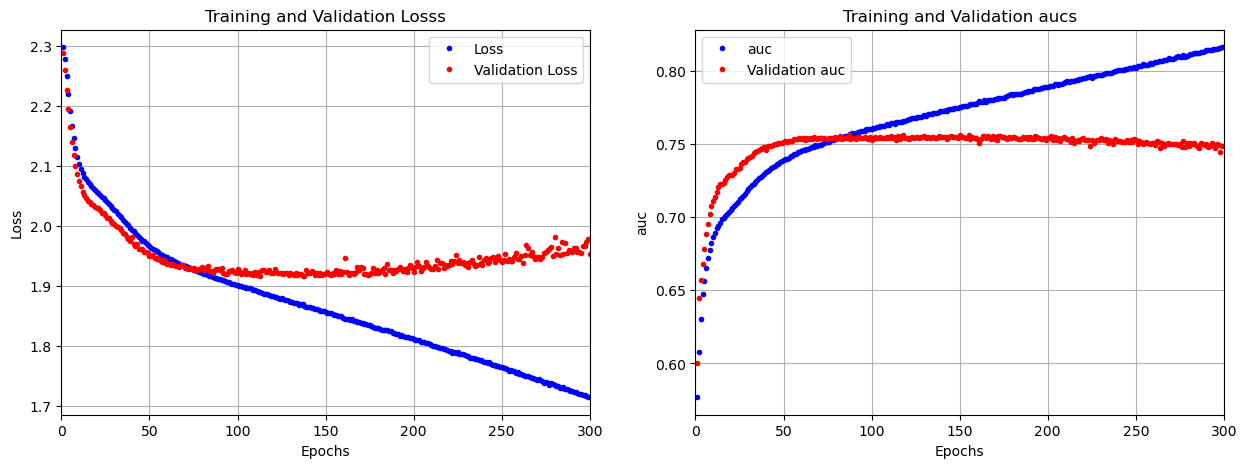

In [208]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [209]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_mlp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Validation): 0.34 (baseline=0.10)
Precision (Validation): 0.67
Recall (Validation): 0.11
AUC (Validation): 0.75


## 7. Regularizing Your Model and Tuning Hyperparameters

Using **Hyperband** for efficient hyperparameter tuning with a frozen architecture.

### Why Hyperband?

**Hyperband** is more efficient than grid search because it:
1. Starts training many configurations for a few epochs
2. Eliminates poor performers early
3. Allocates more resources to promising configurations

In [ ]:
# Hyperband Model Builder for Multi-Class Classification
def build_model_hyperband(hp):
    """
    Build Imagenette model with FROZEN architecture (2 layers: 64 -> 32 neurons).
    Only tunes regularization (Dropout) and learning rate.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(INPUT_DIMENSION,)))

    # Fixed architecture: 2 hidden layers with 64 and 32 neurons
    # Layer 1: 64 neurons
    model.add(layers.Dense(64, activation='relu'))
    drop_0 = hp.Float('drop_0', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_0))

    # Layer 2: 32 neurons
    model.add(layers.Dense(32, activation='relu'))
    drop_1 = hp.Float('drop_1', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_1))

    # Output layer for multi-class classification
    model.add(layers.Dense(OUTPUT_CLASSES, activation='softmax'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=LOSS_FUNC,
        metrics=METRICS
    )
    return model

In [ ]:
# Configure Hyperband tuner
tuner = kt.Hyperband(
    build_model_hyperband,
    objective='val_categorical_accuracy',
    max_epochs=20,
    factor=3,
    directory='imagenette_hyperband',
    project_name='imagenette_tuning'
)

# Run Hyperband search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=batch_size
)

In [223]:
KFOLDS = 5

In [225]:
stats.sort_values(by=['auc'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,categorical_accuracy,precision,recall,auc
2,1,64,relu,0.2,128,129.4,1.933959,0.323221,0.681464,0.071401,0.748485
1,1,32,relu,0.2,128,138.0,1.962195,0.313327,0.695874,0.055908,0.739426
0,1,16,relu,0.2,128,116.8,2.004174,0.294942,0.690630,0.033695,0.724643


In [227]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [229]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.36 (baseline=0.10)
Precision (Validation): 0.73
Recall (Validation): 0.08
AUC (Validation): 0.78


In [ ]:
# Get best hyperparameters and build best model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"  Dropout Layer 1: {best_hp.get('drop_0')}")
print(f"  Dropout Layer 2: {best_hp.get('drop_1')}")
print(f"  Learning Rate: {best_hp.get('lr')}")

opt_model = tuner.hypermodel.build(best_hp)
opt_model.summary()

In [ ]:
# Train the best model
history_opt = opt_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=batch_size,
    verbose=1
)

trained_opt_model = {
    'model': opt_model,
    'val_score': opt_model.evaluate(X_val, y_val, verbose=0)[1:],
    'history': history_opt
}

In [255]:
def top_n_accuracy_score(y, preds, n) :
    scores = []
    for j in range(preds.shape[0]) :
        score = 1 if y[j,:].argmax() in preds[j,:].argsort()[-n:] else 0
        
        scores.append( score )
            
    return sum(scores) / len(scores)

In [271]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

TOP_N = 3
within = top_n_accuracy_score(y_test, preds, TOP_N)

---

## 8. Key Takeaways

1. **TFDS simplifies data loading** - `tfds.load()` handles download, caching, and parsing
2. **Top-N Accuracy** is useful for multi-class problems (model got correct answer in top 3?)
3. **Image preprocessing:** Resize → Grayscale → Flatten sacrifices spatial info for simplicity
4. **CNNs** (not covered here) preserve spatial structure and typically perform better on images

In [272]:
print('Within Top N Accuracy (Test Data): {:.2f}'.format(within))

Within Top N Accuracy (Test Data): 0.60
